# Establishing a baseline for human cortical folding morphological variables: a multicenter study

This work explores novel morphological variables, called K, I, and S. They arise naturally to describe the cortex considering a model in which the cortex folds universally for all mammalian species according to a power-law relation between cortical thickness ($T$), total and exposed areas ($A_t$ and $A_e$).

$$ T^{1/2} A_t = k A_{e}^{\alpha}$$

The main results were:

* A baseline for these cortical folding variables across the human lifespan were established using a heterogeneous compilation of cross-sectional datasets. This is the first step to build up a theory that incorporates the time evolution of brain morphology

* Determination of the uncertainties of the morphological variables due to heterogeneous acquisition and processing.

* The unprecedented possibility of analyzing such a large number of subjects in this framework allowed us to compare CTL and AD subjects’ lifespan trajectories, testing if AD is a form of accelerated aging at the brain structural level

* A morphological detection method for AD

* Time evolution of the fractal index $\alpha$ theoretically calculated as 1.25


In [110]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import arviz as az
from scipy import stats

# Dataset: samples from 9 different databases
rawdata = pd.read_csv("dados_datasetscomp.csv")

df_to_standardize = rawdata[["Age","Gender","Diagnostic","ROI","AvgThickness","TotalArea_corrected","ExposedArea_corrected","Sample","hemi","AB1-40","AB1-42","TAU"]].copy()

# 1. Harmonization

This code implements the harmonization procedure considering that the log of morphological variables linearly decays with age and the type B errors are encoded on the linear coeficient. It is not necessary to re-run as we provide the data fully harmonized.

** The model: **For the morphological variable $y_j$ measured by the j-th sample, one has

$$ y_{j} = ax+b_j$$

In [361]:
var_list = ['AvgThickness', 'TotalArea_corrected','ExposedArea_corrected']
roi_list = list(df_to_standardize["ROI"].unique())
gender_list = list(df_to_standardize["Gender"].unique())

def standardize(dataframe,roi,var_list,gender):
    df = dataframe[(dataframe['ROI'] == roi) & (dataframe['Gender'] == gender) & (dataframe["Diagnostic"] == "CTL")].copy()
    dfout = dataframe[(dataframe['ROI'] == roi) & (dataframe['Gender'] == gender)].copy()

    sample_list = list(df["Sample"].unique())
    nsamples = len(sample_list)
    df["sampleclass"] = df["Sample"].apply(lambda x: sample_list.index(x))
    
    for var in var_list:
        sample_code = df.sampleclass.values
        age = df['Age'].values
        y_val = np.log10(df[var].values)
        
        # Hyperpriors
        with pm.Model() as hierarchical_model:
            a_init_max = (max(y_val) - min(y_val))/90
            a_init_min = -(max(y_val) - min(y_val))/90
            b_init_max = max(y_val)
            b_init_min = min(y_val)
    
            err_init = np.sqrt(np.var(y_val))
    
            mu_a = pm.Uniform('mu_alpha', lower=a_init_min, upper=a_init_max)
            sigma_a = pm.Uniform('sigma_alpha', lower=0, upper=err_init)

            mu_b = pm.Uniform('mu_beta', lower=b_init_min, upper=b_init_max)
            sigma_b = pm.Uniform('sigma_beta', lower=0, upper=err_init)
    
            mu_eps = pm.Uniform('mu_eps', lower=0, upper=err_init)
            sigma_eps = pm.Uniform('sigma_eps', lower=0, upper=err_init)
    
        with hierarchical_model:
            a = pm.Normal('alpha', mu=mu_a, sigma=sigma_a, shape=1)
            b = pm.Normal('beta', mu=mu_b, sigma=sigma_b, shape=nsamples)
            eps = pm.Normal('eps', mu=mu_eps, sigma=sigma_eps, shape=nsamples)
    
            log_y_est =  b[sample_code] + a*age    
    
            lp_like = pm.Normal('lp_like', mu=log_y_est, sigma=eps[sample_code], observed=y_val, total_size=len(y_val))
            trace_model = pm.sample_smc(draws=1000, chains=1)

        mean_a = az.summary(trace_model, var_names=['alpha'], kind="stats",round_to=5)["mean"].to_numpy()
        mean_b = az.summary(trace_model, var_names=['beta'], kind="stats",round_to=5)["mean"].to_numpy() 
        mean_eps = az.summary(trace_model, var_names=['eps'], kind="stats",round_to=5)["mean"].to_numpy() 
        
        ######################################################################
        dfout["sampleclass"] = dfout["Sample"].apply(lambda x: sample_list.index(x))
        
        dfout["newq"] = dfout["sampleclass"].apply(lambda x: np.mean(mean_b) - mean_b[x])
        dfout[var+'new'] = np.log10(dfout[var]) + dfout["newq"] - mean_a[0]*dfout["Age"]
        dfout[var+'new_withAge'] = np.log10(dfout[var]) + dfout["newq"] 
        
        dfout.drop(columns=['newq'], inplace=True)
        with open('Finalresults_xls/fitinfo.txt', 'a+') as f:
            f.write(('ROI:{} - gender:{} - var:{} -- a = {} and b = {}. natural fluct = {}'.format(roi, gender, var, mean_a[0], mean_b, mean_eps)))
        
    writer = pd.ExcelWriter('Finalresults_xls/'+roi+'_'+gender+'_.xlsx')
    dfout.to_excel(writer,index=False)
    writer.save()

In [362]:
# Main loop
# It is not necessary to re-run
for roi in roi_list:
    for gender in gender_list:
        standardize(df_to_standardize,roi,var_list,gender)


Initializing SMC sampler...
Sampling 1 chain in 1 job
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.000
Stage:   3 Beta: 0.000
Stage:   4 Beta: 0.001
Stage:   5 Beta: 0.002
Stage:   6 Beta: 0.003
Stage:   7 Beta: 0.006
Stage:   8 Beta: 0.009
Stage:   9 Beta: 0.013
Stage:  10 Beta: 0.017
Stage:  11 Beta: 0.023
Stage:  12 Beta: 0.031
Stage:  13 Beta: 0.041
Stage:  14 Beta: 0.054
Stage:  15 Beta: 0.072
Stage:  16 Beta: 0.094
Stage:  17 Beta: 0.125
Stage:  18 Beta: 0.165
Stage:  19 Beta: 0.220
Stage:  20 Beta: 0.288
Stage:  21 Beta: 0.382
Stage:  22 Beta: 0.494
Stage:  23 Beta: 0.613
Stage:  24 Beta: 0.811
Stage:  25 Beta: 1.000
/home/victor/.local/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Initializing 

Stage:  20 Beta: 0.407
Stage:  21 Beta: 0.546
Stage:  22 Beta: 0.723
Stage:  23 Beta: 0.969
Stage:  24 Beta: 1.000
Initializing SMC sampler...
Sampling 1 chain in 1 job
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.000
Stage:   3 Beta: 0.000
Stage:   4 Beta: 0.001
Stage:   5 Beta: 0.003
Stage:   6 Beta: 0.004
Stage:   7 Beta: 0.005
Stage:   8 Beta: 0.006
Stage:   9 Beta: 0.008
Stage:  10 Beta: 0.010
Stage:  11 Beta: 0.012
Stage:  12 Beta: 0.015
Stage:  13 Beta: 0.020
Stage:  14 Beta: 0.025
Stage:  15 Beta: 0.031
Stage:  16 Beta: 0.040
Stage:  17 Beta: 0.051
Stage:  18 Beta: 0.064
Stage:  19 Beta: 0.080
Stage:  20 Beta: 0.101
Stage:  21 Beta: 0.130
Stage:  22 Beta: 0.169
Stage:  23 Beta: 0.218
Stage:  24 Beta: 0.281
Stage:  25 Beta: 0.366
Stage:  26 Beta: 0.487
Stage:  27 Beta: 0.648
Stage:  28 Beta: 0.845
Stage:  29 Beta: 1.000
Initializing SMC sampler...
Sampling 1 chain in 1 job
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.000
Stage:   3 Beta: 0

Stage:  30 Beta: 0.866
Stage:  31 Beta: 1.000
Initializing SMC sampler...
Sampling 1 chain in 1 job
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.000
Stage:   3 Beta: 0.000
Stage:   4 Beta: 0.001
Stage:   5 Beta: 0.003
Stage:   6 Beta: 0.006
Stage:   7 Beta: 0.010
Stage:   8 Beta: 0.015
Stage:   9 Beta: 0.021
Stage:  10 Beta: 0.029
Stage:  11 Beta: 0.040
Stage:  12 Beta: 0.054
Stage:  13 Beta: 0.073
Stage:  14 Beta: 0.097
Stage:  15 Beta: 0.128
Stage:  16 Beta: 0.171
Stage:  17 Beta: 0.218
Stage:  18 Beta: 0.280
Stage:  19 Beta: 0.372
Stage:  20 Beta: 0.510
Stage:  21 Beta: 0.668
Stage:  22 Beta: 0.827
Stage:  23 Beta: 1.000
Initializing SMC sampler...
Sampling 1 chain in 1 job
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.000
Stage:   3 Beta: 0.001
Stage:   4 Beta: 0.001
Stage:   5 Beta: 0.003
Stage:   6 Beta: 0.004
Stage:   7 Beta: 0.005
Stage:   8 Beta: 0.007
Stage:   9 Beta: 0.008
Stage:  10 Beta: 0.011
Stage:  11 Beta: 0.014
Stage:  12 Beta: 0

Import the harmonized dataset

In [363]:
import glob

path = 'Finalresults_xls'
all_files = glob.glob(path + "/*.xlsx")

li = []

for filename in all_files:
    df = pd.read_excel(filename, index_col=None, header=0)
    li.append(df)

df_to_analyze = pd.concat(li, axis=0, ignore_index=True)

Calculate the novel morphological variables

In [364]:
# withAge == no deaging
# Power-law relation
df_to_analyze["y"] = 0.5*df_to_analyze["AvgThicknessnew"] + df_to_analyze["TotalArea_correctednew"]
df_to_analyze["x"] = df_to_analyze["ExposedArea_correctednew"]
df_to_analyze["y_withAge"] = 0.5*df_to_analyze["AvgThicknessnew_withAge"] + df_to_analyze["TotalArea_correctednew_withAge"]
df_to_analyze["x_withAge"] = df_to_analyze["ExposedArea_correctednew_withAge"]

# Novel morphological variables
norm1 = np.sqrt( ( (1/4)**2 + 1 + (1.25)**2) )
norm2 = np.sqrt( 6 )
norm3 = np.sqrt( (9/2)**2 + (3/2)**2 + (3/4)**2)

df_to_analyze["K"] = (0.5*df_to_analyze["AvgThicknessnew"] + df_to_analyze["TotalArea_correctednew"] - 1.25*df_to_analyze["ExposedArea_correctednew"])/norm1
df_to_analyze["I"] = (2*df_to_analyze["AvgThicknessnew"] + df_to_analyze["TotalArea_correctednew"] + df_to_analyze["ExposedArea_correctednew"])/norm1
df_to_analyze["S"] = (-9*df_to_analyze["AvgThicknessnew"]/2 + 3*df_to_analyze["TotalArea_correctednew"]/2 + 3*df_to_analyze["ExposedArea_correctednew"]/4)/norm1

df_to_analyze["K_withAge"] = (0.5*df_to_analyze["AvgThicknessnew_withAge"] + df_to_analyze["TotalArea_correctednew_withAge"] - 1.25*df_to_analyze["ExposedArea_correctednew_withAge"])/norm1
df_to_analyze["I_withAge"] = (2*df_to_analyze["AvgThicknessnew_withAge"] + df_to_analyze["TotalArea_correctednew_withAge"] + df_to_analyze["ExposedArea_correctednew_withAge"])/norm2
df_to_analyze["S_withAge"] = (-9*df_to_analyze["AvgThicknessnew_withAge"]/2 + 3*df_to_analyze["TotalArea_correctednew_withAge"]/2 + 3*df_to_analyze["ExposedArea_correctednew_withAge"]/4)/norm3

Plot example: The power-law relation

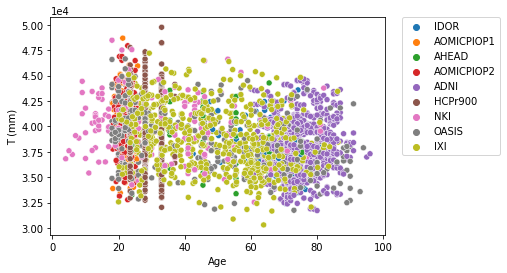

In [459]:
condition = (df_to_analyze["ROI"] == "hemisphere") & (df_to_analyze["hemi"] == "R") & (df_to_analyze["Diagnostic"] == "CTL")
df_to_analyze["var"] = 10**df_to_analyze["ExposedArea_correctednew_withAge"]
ax = sns.scatterplot(x="Age",y="var", hue="Sample", data = df_to_analyze[ condition ])

ax.set(xlabel=r'Age', ylabel=r'T (mm)')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [453]:
from scipy import stats
corr,pval = stats.pearsonr(df_to_analyze["Age"], df_to_analyze["var"])

print(corr, pval)

-0.04848946730906335 6.239130901752375e-21


# 2. Validation of the model

Considering a dataset comprised by $J$ samples where $D_{(j)} = \{ d_{1 (j)}, d_{2 (j)}, \cdots, d_{N_j (j)},\}$ denotes the data in the $j$-th sample. Using the Bayes factor one can compare two or more models M using:

$$P(M|D_{(j)}) \propto \int_{\Delta A_{(j)\beta}} d A_{(j)\beta} \prod_{i=1}^{N_{(j)}} \frac{1}{\sigma_{(j)} \sqrt{2 \pi}} \exp{ [y_{i(j)} - \mu(x_{i(j)}, A_{(j)\beta}]^2/2\sigma_{(j)}^2}$$

$$P(M|D) \propto \prod_{j=1}^{J} \int_{\Delta A_{(j)\beta}} d A_{(j)\beta} \prod_{i=1}^{N_{(j)}} \frac{1}{\sigma_{(j)} \sqrt{2 \pi}} \exp{ [y_{i(j)} - \mu(x_{i(j)}, A_{(j)\beta})]^2/2\sigma_{(j)}^2}$$

The term $ \mu(x_{i(j)}, A_{(j)\beta}) $ is given by the model M proposed to describe the data, with the set $\{A_{(j)\beta} \}$ being the free parameters defined in the range $\Delta A_{(j)\beta}$. The basic model of this work assumes that the morphological variables follow $\mu = ax+b_{(j)}$, with the same dispersion $\sigma_{(j)} = \sigma$ for all samples. We showed that this model is the most probable

* References of Bayesian statistics

In [402]:
# Example for the time evolution of the mean thickness
condition = (df_to_analyze['Gender'] == 'MASC') & (df_to_analyze['Diagnostic'] == 'CTL') & (df_to_analyze['ROI'] == 'hemisphere') & (df_to_analyze['hemi'] == 'R')

sample_list = list(df_to_analyze["Sample"].unique())
nsamples = len(sample_list)
df_to_analyze["sampleclass"] = df_to_analyze["Sample"].apply(lambda x: sample_list.index(x))

sample_code = df_to_analyze[ condition ].sampleclass.values
age = df_to_analyze[ condition ].Age.values
y_val = np.log10(df_to_analyze[ condition ].AvgThickness.values)

**Model 1:** $\mu = ax+b_{(j)}$ with the same dispersion $\sigma_{(j)} = \sigma$ for all samples

In [403]:
with pm.Model() as hierarchical_model_1:
    a_init_max = (max(y_val) - min(y_val))/90
    a_init_min = -(max(y_val) - min(y_val))/90
    b_init_max = max(y_val)
    b_init_min = min(y_val)
    
    err_init = np.sqrt(np.var(y_val))
    
    mu_a = pm.Uniform('mu_alpha', lower=a_init_min, upper=a_init_max)
    sigma_a = pm.Uniform('sigma_alpha', lower=0, upper=err_init)

    mu_b = pm.Uniform('mu_beta', lower=b_init_min, upper=b_init_max)
    sigma_b = pm.Uniform('sigma_beta', lower=0, upper=err_init)
    
    mu_eps = pm.Uniform('mu_eps', lower=0, upper=err_init)
    sigma_eps = pm.Uniform('sigma_eps', lower=0, upper=err_init)

with hierarchical_model_1:
    a = pm.Normal('alpha', mu=mu_a, sigma=sigma_a, shape=1)
    b = pm.Normal('beta', mu=mu_b, sigma=sigma_b, shape=nsamples)
    eps = pm.Normal('eps', mu=mu_eps, sigma=sigma_eps, shape=nsamples)
    
    log_y_est =  b[sample_code] + a*age    
    lp_like = pm.Normal('lp_like', mu=log_y_est, sigma=eps[sample_code], observed=y_val, total_size=len(y_val))
    trace_model_1 = pm.sample_smc(draws=4000, chains=1, random_seed=42)


Initializing SMC sampler...
Sampling 1 chain in 1 job
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.000
Stage:   3 Beta: 0.000
Stage:   4 Beta: 0.001
Stage:   5 Beta: 0.004
Stage:   6 Beta: 0.009
Stage:   7 Beta: 0.015
Stage:   8 Beta: 0.022
Stage:   9 Beta: 0.032
Stage:  10 Beta: 0.044
Stage:  11 Beta: 0.061
Stage:  12 Beta: 0.085
Stage:  13 Beta: 0.115
Stage:  14 Beta: 0.156
Stage:  15 Beta: 0.203
Stage:  16 Beta: 0.257
Stage:  17 Beta: 0.327
Stage:  18 Beta: 0.428
Stage:  19 Beta: 0.566
Stage:  20 Beta: 0.734
Stage:  21 Beta: 0.935
Stage:  22 Beta: 1.000


**Model 2:** $\mu = a_{(j)}x+b_{(j)}$ with the same dispersion $\sigma_{(j)} = \sigma$ for all samples

In [393]:
with pm.Model() as hierarchical_model_2:
    a_init_max = (max(y_val) - min(y_val))/90
    a_init_min = -(max(y_val) - min(y_val))/90
    b_init_max = max(y_val)
    b_init_min = min(y_val)
    
    err_init = np.sqrt(np.var(y_val))
    
    mu_a = pm.Uniform('mu_alpha', lower=a_init_min, upper=a_init_max)
    sigma_a = pm.Uniform('sigma_alpha', lower=0, upper=err_init)

    mu_b = pm.Uniform('mu_beta', lower=b_init_min, upper=b_init_max)
    sigma_b = pm.Uniform('sigma_beta', lower=0, upper=err_init)
    
    mu_eps = pm.Uniform('mu_eps', lower=0, upper=err_init)
    sigma_eps = pm.Uniform('sigma_eps', lower=0, upper=err_init)

with hierarchical_model_2:
    a = pm.Normal('alpha', mu=mu_a, sigma=sigma_a, shape=nsamples)
    b = pm.Normal('beta', mu=mu_b, sigma=sigma_b, shape=nsamples)
    eps = pm.Normal('eps', mu=mu_eps, sigma=sigma_eps, shape=1)
    
    log_y_est =  b[sample_code] + a[sample_code]*age    
    lp_like = pm.Normal('lp_like', mu=log_y_est, sigma=eps, observed=y_val, total_size=len(y_val))
    trace_model_2 = pm.sample_smc(draws=1000, chains=1, random_seed=42)

Initializing SMC sampler...
Sampling 1 chain in 1 job
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.000
Stage:   3 Beta: 0.000
Stage:   4 Beta: 0.001
Stage:   5 Beta: 0.002
Stage:   6 Beta: 0.030
Stage:   7 Beta: 0.047
Stage:   8 Beta: 0.057
Stage:   9 Beta: 0.066
Stage:  10 Beta: 0.077
Stage:  11 Beta: 0.091
Stage:  12 Beta: 0.112
Stage:  13 Beta: 0.134
Stage:  14 Beta: 0.156
Stage:  15 Beta: 0.189
Stage:  16 Beta: 0.232
Stage:  17 Beta: 0.271
Stage:  18 Beta: 0.335
Stage:  19 Beta: 0.667
Stage:  20 Beta: 0.953
Stage:  21 Beta: 1.000


**Model 3:** $\mu = ax+b_{(j)}$ with different dispersion $\sigma_{(j)}$ for the samples

In [404]:
with pm.Model() as hierarchical_model_3:
    a_init_max = (max(y_val) - min(y_val))/90
    a_init_min = -(max(y_val) - min(y_val))/90
    b_init_max = max(y_val)
    b_init_min = min(y_val)
    
    err_init = np.sqrt(np.var(y_val))
    
    mu_a = pm.Uniform('mu_alpha', lower=a_init_min, upper=a_init_max)
    sigma_a = pm.Uniform('sigma_alpha', lower=0, upper=err_init)

    mu_b = pm.Uniform('mu_beta', lower=b_init_min, upper=b_init_max)
    sigma_b = pm.Uniform('sigma_beta', lower=0, upper=err_init)
    
    mu_eps = pm.Uniform('mu_eps', lower=0, upper=err_init)
    sigma_eps = pm.Uniform('sigma_eps', lower=0, upper=err_init)

with hierarchical_model_3:
    a = pm.Normal('alpha', mu=mu_a, sigma=sigma_a, shape=1)
    b = pm.Normal('beta', mu=mu_b, sigma=sigma_b, shape=nsamples)
    eps = pm.Normal('eps', mu=mu_eps, sigma=sigma_eps, shape=1)
    
    log_y_est =  b[sample_code] + a*age    
    lp_like = pm.Normal('lp_like', mu=log_y_est, sigma=eps, observed=y_val, total_size=len(y_val))
    trace_model_3 = pm.sample_smc(draws=4000, chains=1, random_seed=42)


Initializing SMC sampler...
Sampling 1 chain in 1 job
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.000
Stage:   3 Beta: 0.001
Stage:   4 Beta: 0.002
Stage:   5 Beta: 0.006
Stage:   6 Beta: 0.010
Stage:   7 Beta: 0.016
Stage:   8 Beta: 0.023
Stage:   9 Beta: 0.034
Stage:  10 Beta: 0.051
Stage:  11 Beta: 0.076
Stage:  12 Beta: 0.113
Stage:  13 Beta: 0.172
Stage:  14 Beta: 0.261
Stage:  15 Beta: 0.371
Stage:  16 Beta: 0.521
Stage:  17 Beta: 0.795
Stage:  18 Beta: 1.000


**Model 4:** $\mu = a_{(j)}x+b_{(j)}$ with different dispersion $\sigma_{(j)} $ for the samples

In [395]:
with pm.Model() as hierarchical_model_4:
    a_init_max = (max(y_val) - min(y_val))/90
    a_init_min = -(max(y_val) - min(y_val))/90
    b_init_max = max(y_val)
    b_init_min = min(y_val)
    
    err_init = np.sqrt(np.var(y_val))
    
    mu_a = pm.Uniform('mu_alpha', lower=a_init_min, upper=a_init_max)
    sigma_a = pm.Uniform('sigma_alpha', lower=0, upper=err_init)

    mu_b = pm.Uniform('mu_beta', lower=b_init_min, upper=b_init_max)
    sigma_b = pm.Uniform('sigma_beta', lower=0, upper=err_init)
    
    mu_eps = pm.Uniform('mu_eps', lower=0, upper=err_init)
    sigma_eps = pm.Uniform('sigma_eps', lower=0, upper=err_init)

with hierarchical_model_4:
    a = pm.Normal('alpha', mu=mu_a, sigma=sigma_a, shape=nsamples)
    b = pm.Normal('beta', mu=mu_b, sigma=sigma_b, shape=nsamples)
    eps = pm.Normal('eps', mu=mu_eps, sigma=sigma_eps, shape=nsamples)
    
    log_y_est =  b[sample_code] + a[sample_code]*age    
    lp_like = pm.Normal('lp_like', mu=log_y_est, sigma=eps[sample_code], observed=y_val, total_size=len(y_val))
    trace_model_4 = pm.sample_smc(draws=1000, chains=1, random_seed=42)


Initializing SMC sampler...
Sampling 1 chain in 1 job
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.000
Stage:   3 Beta: 0.000
Stage:   4 Beta: 0.000
Stage:   5 Beta: 0.001
Stage:   6 Beta: 0.001
Stage:   7 Beta: 0.002
Stage:   8 Beta: 0.004
Stage:   9 Beta: 0.006
Stage:  10 Beta: 0.009
Stage:  11 Beta: 0.014
Stage:  12 Beta: 0.019
Stage:  13 Beta: 0.027
Stage:  14 Beta: 0.039
Stage:  15 Beta: 0.054
Stage:  16 Beta: 0.069
Stage:  17 Beta: 0.084
Stage:  18 Beta: 0.106
Stage:  19 Beta: 0.130
Stage:  20 Beta: 0.153
Stage:  21 Beta: 1.000


Defining the odds as $\mathcal{O}_{ij} = \frac{p(M_i|D)}{p(M_j|D)}$. As $\sum_{i} p(M_i| D) = 1$, the probability of the model $M_1$ is given by:

$$p(M_1) = \frac{1}{1+\sum_{i} \mathcal{O}_{i1} }$$

In [405]:
o21 = np.exp(trace_model_2.report.log_marginal_likelihood - trace_model_1.report.log_marginal_likelihood)
o31 = np.exp(trace_model_3.report.log_marginal_likelihood - trace_model_1.report.log_marginal_likelihood)
o41 = np.exp(trace_model_4.report.log_marginal_likelihood - trace_model_1.report.log_marginal_likelihood)
prob = 1/(1+o21+o31+o41)

print(prob,o21,o31,o41)

[1.] [3.2217676e-197] [1.28962466e-12] [2.66748732e-105]


In [398]:
az.summary(trace_model_1, var_names=['eps','alpha','beta'], kind="stats", round_to=5)

/home/victor/.local/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
eps[0],0.01140,0.00247,0.00641,0.01562
eps[1],0.01353,0.00120,0.01128,0.01597
eps[2],0.01715,0.00224,0.01319,0.02071
eps[3],0.01567,0.00135,0.01350,0.01859
eps[4],0.02205,0.00087,0.02032,0.02346
eps[5],0.01533,0.00068,0.01395,0.01657
eps[6],0.01863,0.00150,0.01574,0.02142
eps[7],0.02034,0.00134,0.01849,0.02339
eps[8],0.01604,0.00138,0.01412,0.01914
alpha[0],-0.00080,0.00005,-0.00087,-0.00071


# Some results

# Time evolution of Morphological variables

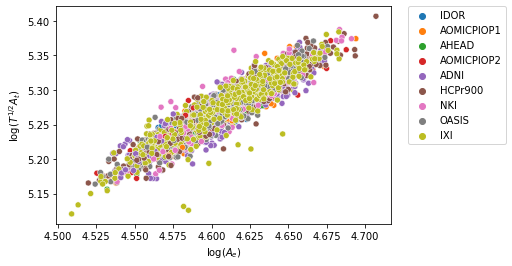

In [457]:
condition = (df_to_analyze["ROI"] == "hemisphere") & (df_to_analyze["hemi"] == "R") & (df_to_analyze["Diagnostic"] == "CTL")
ax = sns.scatterplot(x="x",y="y", hue="Sample", data = df_to_analyze[ condition ])

ax.set(xlabel=r'log($A_e$)', ylabel=r'log($T^{1/2}A_t$)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# 5. Time evolution of $\alpha$

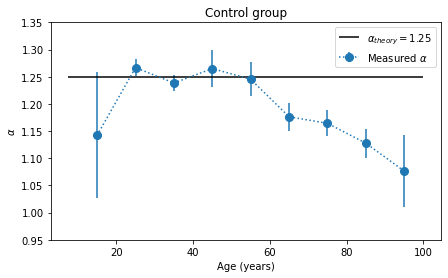

In [409]:
from scipy import stats
x1 = []
y1 = []
y1err = []

for i in np.arange(5,95,10):
    condition = (df_to_analyze["ROI"] == "hemisphere") & (df_to_analyze["Diagnostic"] == "CTL") & (df_to_analyze["hemi"] == "R") & (df_to_analyze['Age']>i) & (df_to_analyze['Age']<i+10)
    df = df_to_analyze[condition]
    x_val = df.x_withAge.values
    y_val = df.y_withAge.values
    
    result = stats.linregress(x_val, y_val)
    
    x1.append(i+10)
    y1.append(result.slope)
    y1err.append(result.stderr)    

ls = 'dotted'
fig, ax = plt.subplots(figsize=(7, 4))

ax.errorbar(x1, y1, yerr=y1err,marker='o', markersize=8,linestyle=ls, label=r'Measured $\alpha$')

# tidy up the figure
ax.set_title('Control group')
ax.set_xlabel('Age (years)')
ax.set_ylabel(r'$ \alpha $')
plt.hlines(1.25, 7.5, 100, colors="black", linestyles='solid', label=r"$\alpha_{theory} = 1.25$")
plt.ylim([0.95, 1.35])
plt.legend()
plt.show()

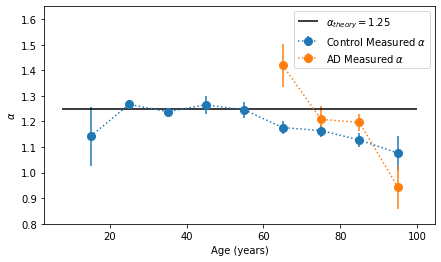

In [400]:
# Hard coded but Ok
from scipy import stats
x1 = []
y1 = []
y1err = []

for i in np.arange(5,95,10):
    condition = (df_to_analyze["ROI"] == "hemisphere") & (df_to_analyze["Diagnostic"] == "CTL") & (df_to_analyze["hemi"] == "R") & (df_to_analyze['Age']>i) & (df_to_analyze['Age']<i+10)
    df = df_to_analyze[condition]
    x_val = df.x_withAge.values
    y_val = df.y_withAge.values
    
    result = stats.linregress(x_val, y_val)
    
    x1.append(i+10)
    y1.append(result.slope)
    y1err.append(result.stderr)    

ls = 'dotted'
fig, ax = plt.subplots(figsize=(7, 4))

ax.errorbar(x1, y1, yerr=y1err,marker='o', markersize=8,linestyle=ls, label=r'Control Measured $\alpha$')

x1 = []
y1 = []
y1err = []

for i in np.arange(55,95,10):
    condition = (df_to_analyze["ROI"] == "hemisphere") & (df_to_analyze["Diagnostic"] == "AD") & (df_to_analyze["hemi"] == "L") & (df_to_analyze['Age']>i) & (df_to_analyze['Age']<i+10)
    df = df_to_analyze[condition]
    x_val = df.x_withAge.values
    y_val = df.y_withAge.values
    
    result = stats.linregress(x_val, y_val)
    
    x1.append(i+10)
    y1.append(result.slope)
    y1err.append(result.stderr)    

ax.errorbar(x1, y1, yerr=y1err,marker='o', markersize=8,linestyle=ls, label=r'AD Measured $\alpha$')

# tidy up the figure
#ax.set_title('Control group')
ax.set_xlabel('Age (years)')
ax.set_ylabel(r'$ \alpha $')
plt.hlines(1.25, 7.5, 100, colors="black", linestyles='solid', label=r"$\alpha_{theory} = 1.25$")
plt.ylim([0.8, 1.65])
plt.legend()
plt.show()